In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import os
import numpy as np
import torch as t
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('/home/ubuntu/PyMAD/') # TODO: Make this relative path maybe
sys.path.append('/home/ubuntu/TSADModelSelection')

from src.pymad.datasets.load import load_data
from src.pymad.loaders.loader import Loader
from src.pymad.training_args import TrainingArguments
from src.pymad.trainer import Trainer

# Import all the models
from src.pymad.models.DGHL import DGHL
from src.pymad.models.RNN import RNN
from src.pymad.models.LSTMVAE import LSTMVAE
from src.pymad.models.MeanDeviation import MeanDeviation
from src.pymad.models.RunningMean import RunningMean
from src.pymad.models.NearestNeighbors import NearestNeighbors as NN

from metrics.metrics import mse, mae, smape, mape, prauc, ndcg
from scipy.stats import spearmanr, kendalltau
from sklearn.neighbors import NearestNeighbors

## Train PyMAD Models

In [11]:
# Load the data
ENTITY = 'A-1'
DATASET = 'msl' # 'anomaly_archive'  'smd' 
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=None, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=None, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)

Text(0.5, 1.0, 'Test data')

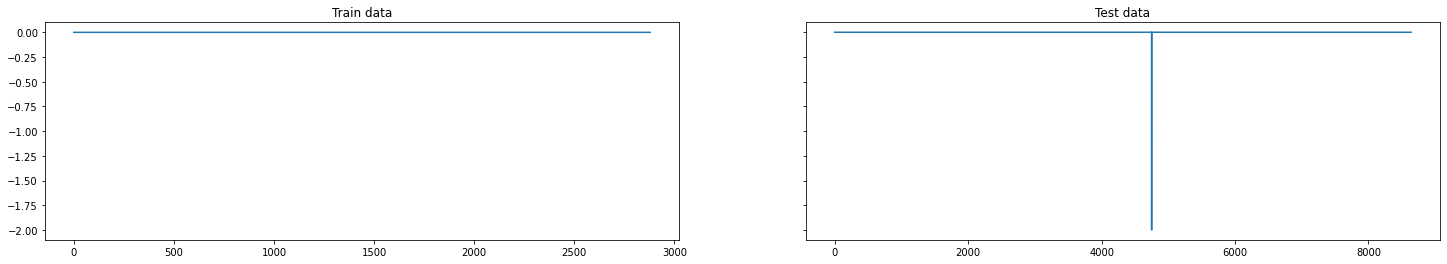

In [12]:
# Visualize the train and the test data

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(25, 4))
axes[0].plot(train_data.entities[0].Y.flatten())
axes[0].set_title('Train data')
axes[1].plot(test_data.entities[0].Y.flatten())
axes[1].set_title('Test data')

### Mean Deviation

In [16]:
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)

# Declare training parameters
train_hyper_params = {
                'output_dir': r'/output',
                'overwrite_output_dir': True, 
                'train_batch_size': 128, 
                'learning_rate': 1e-3, 
                'seed': 1, 
                'max_steps': 200,
                'eval_batch_size': 128,
                'eval_freq': 500
                }
# Declare model parameters
model_hyper_params = {
                'n_features': train_data.entities[0].Y.shape[0], 
                'window_size': 64, 
                'window_step': 64,
                'device': None
                }

# Initialize the model and the training arguments
training_args = TrainingArguments(**train_hyper_params)
model = MeanDeviation(**model_hyper_params)

trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=train_data, 
                  eval_dataset=None, 
                  verbose=False)
trainer.train()

100%|██████████| 200/200 [00:00<00:00, 546.97it/s]


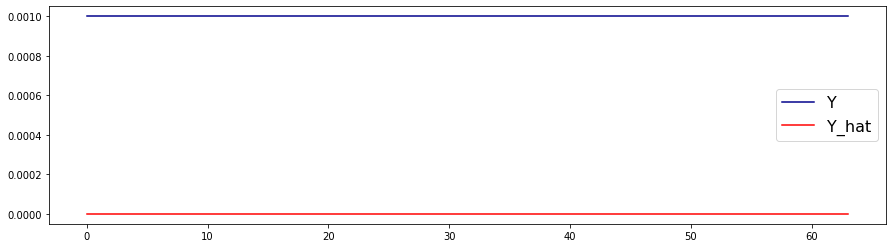

In [17]:
# Declare the eval data loader
dataloader = Loader(dataset=test_data, 
                    batch_size=8, 
                    window_size=64,
                    window_step=64,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

trainer.model.eval()

# We'll just visualize the prediction in the first batch
for batch in dataloader:
    Y, Y_hat, mask = trainer.model.forward(batch)
    Y, Y_hat, mask = Y.detach().cpu().numpy(), Y_hat.detach().cpu().numpy(), mask.detach().cpu().numpy()
    break

batch_num = 2
feature_num = 0
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
axes.plot(Y[batch_num, feature_num, :].flatten(), c='darkblue', label='Y')
axes.plot(Y_hat[batch_num, feature_num, :].flatten(), c='red', label='Y_hat')
axes.legend(fontsize=16)

### DGHL

In [32]:
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=None, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=None, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)

# Declare training parameters
train_hyper_params = {'output_dir': r'/output',
                    'overwrite_output_dir': True, 
                    'train_batch_size': 8, 
                    'learning_rate': 1e-3, 
                    'seed': 1, 
                    'max_steps': 200,
                    'eval_batch_size': 16,
                    'eval_freq': 500
                    }

# Declare model parameters
model_hyper_params = {
                    'window_size' : 64, 
                    'window_step' : 64, 
                    'n_features' : train_data.entities[0].Y.shape[0] + train_data.entities[0].X.shape[0], 
                    'hidden_multiplier' : 32, 
                    'max_filters' : 256, 
                    'kernel_multiplier' : 1,
                    'a_L' : 4,
                    'z_size' : 5, # Size of latent z vector [5, 25, 50]
                    'z_size_up' : 5, 
                    'z_iters' : 25, # Number of iteration in the Langevyn dynamics inference formula. [5, 25, 100] -- more the better and slower. Linear time dependence. 
                    'z_iters_inference' : 100, # Higher the better -> 300, 500 better. 
                    'z_sigma' : 0.25, 
                    'z_step_size' : 0.1, 
                    'z_with_noise' : False, 
                    'z_persistent' : False, # Can only be False currently. = True means that it will start from the last latent vector when it observed the particular window. Therefore it needs higher z_iters right now. 
                    'normalize_windows' : False, 
                    'noise_std' : 0.001,  
                    'random_seed' : 1, 
                    'device': None
                    }

training_args = TrainingArguments(**train_hyper_params)
model = DGHL(**model_hyper_params)

trainer = Trainer(model=model, 
                args=training_args, 
                train_dataset=train_data, 
                eval_dataset=None, 
                verbose=False)
trainer.train()
trainer.model.eval()

AssertionError: Batch n_features 25 not consistent with Generator

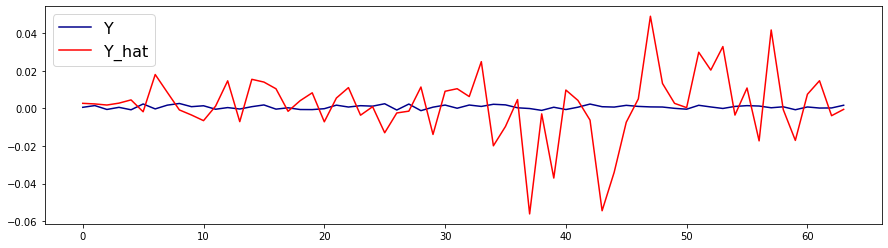

In [24]:
# Declare the eval data loader
dataloader = Loader(dataset=test_data, 
                    batch_size=8, 
                    window_size=64,
                    window_step=64,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

for batch in dataloader:
    Y, Y_hat, mask = trainer.model.forward(batch)
    Y, Y_hat, mask = Y.detach().cpu().numpy(), Y_hat.detach().cpu().numpy(), mask.detach().cpu().numpy()
    break

batch_num = 2
feature_num = 0
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
axes.plot(Y[batch_num, feature_num, :].flatten(), c='darkblue', label='Y')
axes.plot(Y_hat[batch_num, feature_num, :].flatten(), c='red', label='Y_hat')
axes.legend(fontsize=16)

### LSTMVAE

In [25]:
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)

train_hyper_params = {'output_dir': r'/output',
                    'overwrite_output_dir': True, 
                    'train_batch_size': 64, 
                    'learning_rate': 0.0005, 
                    'max_steps': 1000,
                    'eval_batch_size': 128,
                    'eval_freq': 500
                    }

model_hyper_params = {
                    'window_size' : 64, 
                    'window_step' : 64, 
                    'n_features' : train_data.entities[0].Y.shape[0], 
                    'hidden_size' : 256, # hidden_size – The number of features in the hidden state h
                    'latent_size' : 128, # Size of the latent z 
                    'num_layers' : 4, # Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
                    'noise_std' : 0.001,  
                    'random_seed' : 1, 
                    'device': None
                    }

training_args = TrainingArguments(**train_hyper_params)
model = LSTMVAE(**model_hyper_params)

trainer = Trainer(model=model, 
                args=training_args, 
                train_dataset=train_data, 
                eval_dataset=None, 
                verbose=False)
trainer.train()
trainer.model.eval()

100%|██████████| 1000/1000 [00:31<00:00, 32.16it/s]


LSTMVAE(
  (model): _LSTMVAE(
    (lstm_encoder): LSTM(1, 256, num_layers=4)
    (lstm_decoder): LSTM(128, 256, num_layers=4)
    (hidden_mu): Linear(in_features=256, out_features=128, bias=True)
    (hidden_logvar): Linear(in_features=256, out_features=128, bias=True)
    (x_mu): Linear(in_features=256, out_features=1, bias=True)
    (x_sigma): Linear(in_features=256, out_features=1, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
  )
  (gaussianNLL): GaussianNLLLoss()
  (reconstruction_loss): GaussianNLLLoss()
)

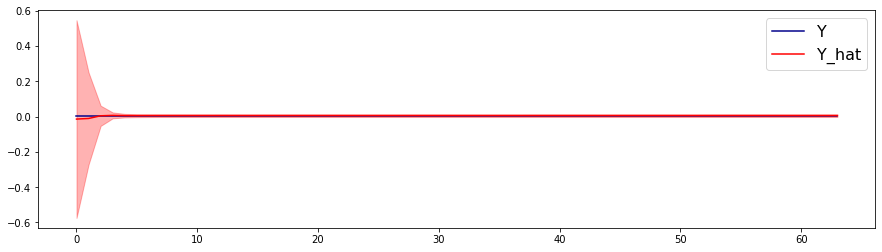

In [26]:
# Declare the eval data loader
dataloader = Loader(dataset=test_data, 
                    batch_size=8, 
                    window_size=64,
                    window_step=64,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

trainer.model.eval()

# We'll just visualize the prediction in the first batch
for batch in dataloader:
    Y, Y_mu, mask, Y_sigma, Z_mu, Z_sigma, Z = trainer.model.forward(batch)
    Y, Y_mu, mask, Y_sigma, Z_mu, Z_sigma, Z = Y.detach().cpu().numpy(), Y_mu.detach().cpu().numpy(), mask.detach().cpu().numpy(), Y_sigma.detach().cpu().numpy(), Z_mu.detach().cpu().numpy(), Z_sigma.detach().cpu().numpy(), Z.detach().cpu().numpy()
    break

batch_num = 2
feature_num = 0
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
axes.plot(Y[batch_num, feature_num, :].flatten(), c='darkblue', label='Y')
axes.plot(Y_mu[batch_num, feature_num, :].flatten(), c='red', label='Y_hat')
axes.fill_between(x=np.arange(len(Y_mu[batch_num, feature_num, :])), y1=Y_mu[batch_num, feature_num, :]+Y_sigma[batch_num, feature_num, :], y2=Y_mu[batch_num, feature_num, :]-Y_sigma[batch_num, feature_num, :], color='r', alpha=0.3)
axes.legend(fontsize=16)

### NearestNeighbors

In [27]:
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)

model_hyper_params = {
                    'window_size' : 128, 
                    'window_step' : 64, 
                    'n_neighbors' : 5, 
                    }

model = NN(**model_hyper_params)

dataloader = Loader(dataset=train_data, 
                    batch_size=8, 
                    window_size=64,
                    window_step=64,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

model.fit(dataloader)

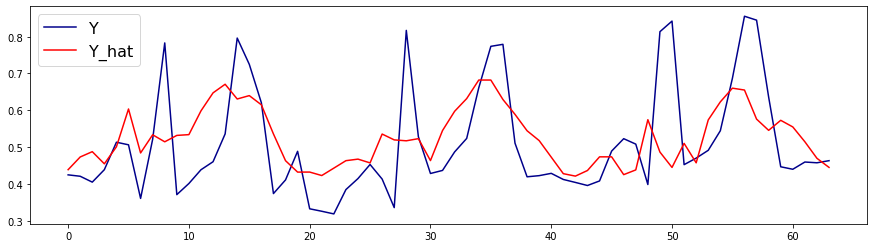

In [14]:
# Declare the eval data loader
dataloader = Loader(dataset=test_data, 
                    batch_size=8, 
                    window_size=64,
                    window_step=64,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

# We'll just visualize the prediction in the first batch
for batch in dataloader:
    Y, Y_hat, mask = model.forward(batch)
    break

batch_num = 2
feature_num = 0
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
axes.plot(Y[batch_num, feature_num, :].flatten(), c='darkblue', label='Y')
axes.plot(Y_hat[batch_num, feature_num, :].flatten(), c='red', label='Y_hat')
axes.legend(fontsize=16)

### Running Mean

In [28]:
model_hyper_params = {
                    'n_features': train_data.entities[0].Y.shape[0],
                    'window_size': -1, 
                    'window_step' : -1, 
                    'running_window_size': 4, 
                    }
model = RunningMean(**model_hyper_params)

# Running mean does not need a data loader

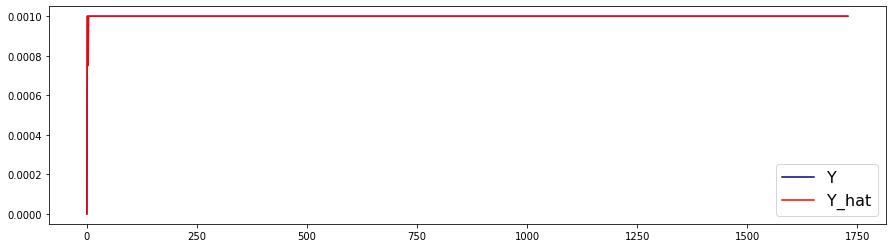

In [29]:
# Declare the eval data loader
dataloader = Loader(dataset=test_data, 
                    batch_size=1, 
                    window_size=-1,
                    window_step=-1,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

# We'll just visualize the prediction in the first batch
for batch in dataloader:
    Y, Y_hat, mask = model.forward(batch)
    break

batch_num = 0
feature_num = 0
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
axes.plot(Y[feature_num, :].flatten(), c='darkblue', label='Y')
axes.plot(Y_hat[feature_num, :].flatten(), c='red', label='Y_hat')
axes.legend(fontsize=16)

### RNN

In [30]:
train_data = load_data(dataset=DATASET, group='train', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)
test_data = load_data(dataset=DATASET, group='test', entities=[ENTITY], downsampling=5, root_dir='/home/ubuntu/datasets/', normalize=True, verbose=False)


train_hyper_params = {'output_dir': r'/output',
                    'overwrite_output_dir': True, 
                    'train_batch_size': 1, 
                    'learning_rate': 0.01, 
                    'seed': 1, 
                    'max_steps': 100,
                    }

model_hyper_params = {
                    'window_size' : -1, 
                    'window_step' : -1, 
                    'input_size' : 32, # Number of lags for every timestamp -- size of context
                    'output_size' : 8, # How many steps does it predict in future?  
                    'sample_freq' : 8, 
                    'n_t' : 0, 
                    'cell_type' : 'LSTM',  
                    'dilations' : [[1, 2], [4, 8]], 
                    'state_hsize': 256,
                    'add_nl_layer' : False,  
                    'random_seed' : 1, 
                    'device': None,
                    }

training_args = TrainingArguments(**train_hyper_params)
model = RNN(**model_hyper_params)

trainer = Trainer(model=model, 
                args=training_args, 
                train_dataset=train_data, 
                eval_dataset=None, 
                verbose=False)
trainer.train()
trainer.model.eval()

100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


RNN(
  (model): _RNN(
    (rnn_stack): Sequential(
      (0): DRNN(
        (cells): Sequential(
          (0): LSTM(32, 256)
          (1): LSTM(256, 256)
        )
      )
      (1): DRNN(
        (cells): Sequential(
          (0): LSTM(256, 256)
          (1): LSTM(256, 256)
        )
      )
    )
    (adapterW): Linear(in_features=256, out_features=8, bias=True)
  )
)

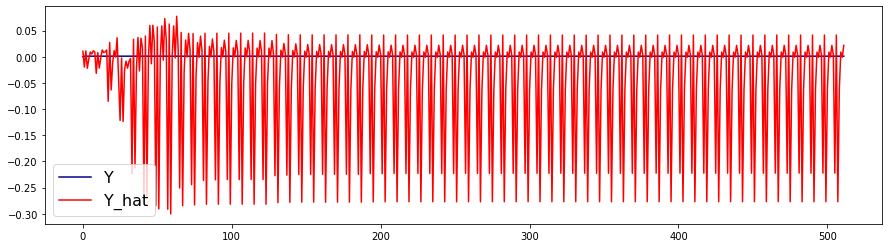

In [31]:
# Declare the eval data loader
dataloader = Loader(dataset=test_data, 
                    batch_size=1, 
                    window_size=-1,
                    window_step=-1,
                    shuffle=False, 
                    padding_type='right', 
                    sample_with_replace=False, 
                    verbose=False, 
                    mask_position='None', 
                    n_masked_timesteps=0) 

# We'll just visualize the prediction in the first batch
for batch in dataloader:
    batch_size, n_features, window_size = batch['Y'].shape
    Y, Y_hat, mask = trainer.model.forward(batch)
    
    Y, Y_hat, mask = Y.detach().cpu().numpy(), Y_hat.detach().cpu().numpy(), mask.detach().cpu().numpy()
    Y = Y.reshape(n_features, -1)[:,:window_size] # to [n_features, n_time]
    Y_hat = Y_hat.reshape(n_features, -1)[:,:window_size]  # to [n_features, n_time]
    mask = mask.reshape(n_features, -1)[:,:window_size]  # to [n_features, n_time]

    break

feature_num = 0
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
axes.plot(Y[feature_num, :512], c='darkblue', label='Y')
axes.plot(Y_hat[feature_num, :512], c='red', label='Y_hat')
axes.legend(fontsize=16)